<a href="https://colab.research.google.com/github/OJB-Quantum/Generative-Layout-Notebooks/blob/main/Spintronic_H_Bridge_Inverter_Using_GDSTK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# %% Install dependencies (fast on Colab)
!pip install --quiet phidl gdstk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.4/109.4 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.9/157.9 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 534.7/534.7 kB 31.3 MB/s eta 0:00:00


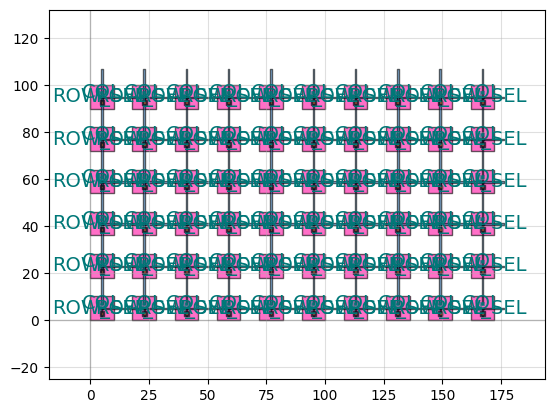

✅ Exported spin_hbridge_array_60.gds


In [5]:
"""Spin‑Compatible H‑Bridge Array (60 channels) — MTJ / ISHE Readout
====================================================================
New notebook cell that builds on the previous CMOS H‑bridge cell but adds:
  • Magnetic Tunnel Junction (MTJ) or Inverse Spin‑Hall (ISHE) detector
    connected at each H‑bridge output.
  • Row/column pass‑transistor multiplexing so only one OUT current is
    routed to a global CHARGE_CURRENT bus at a time.
  • Example: 10 × 6 grid = 60 spin‑readout channels.

*All geometries are illustrative; swap layer numbers & dimensions per PDK.*
"""

# %% Imports & layer map (reuse previous map or redefine here)
import phidl
from phidl import Device, quickplot as qp
import phidl.geometry as pg
import gdstk
import matplotlib.pyplot as plt

LAYER = {
    "metal1": (68, 20),
    "metal2": (70, 20),
    "via12" : (69, 20),
    "mtj"   : (71, 0),   # placeholder MTJ sensing element
    "contact": (67, 44),
}

# %% Primitive • MTJ / ISHE detector (simple rectangle + vias)

def mtj_device(size=(1.2, 1.2)):
    D = Device("MTJ")
    # Ferromagnetic stack rectangle
    D.add_ref(pg.rectangle(size=size, layer=LAYER["mtj"]))
    # Top M2 pad + via stack to M1
    pad = pg.rectangle((size[0]+0.8, size[1]+0.8), layer=LAYER["metal2"])
    p_ref = D.add_ref(pad).move((-0.4, -0.4))
    via = pg.rectangle((0.4, 0.4), layer=LAYER["via12"])
    v_ref = D.add_ref(via).move((size[0]/2 - 0.2, size[1]/2 - 0.2))
    # Ports: bottom (M1) and top (M2) for current readout
    D.add_port("IN", midpoint=(size[0]/2, -0.2), width=0.4, orientation=-90)
    D.add_port("OUT", midpoint=p_ref.center, width=size[0]+0.8, orientation=90)
    return D

# %% Wrapper • Spin‑ready H‑bridge cell (H‑bridge + MTJ + pass FET)
from phidl.geometry import rectangle

def spin_hbridge(base_cell):
    C = Device("SPIN_HBRIDGE")
    # Place the earlier H‑bridge (expects port "OUT")
    h = C.add_ref(base_cell)

    # Place MTJ beneath the OUT bar
    mtj = C.add_ref(mtj_device())
    mtj.move((h.ports["OUT"].midpoint[0] - 0.6, h.ports["OUT"].midpoint[1] - 3))
    # Tie H‑bridge OUT → MTJ IN with a short M1 strap
    strap = pg.rectangle((0.4, 3), layer=LAYER["metal1"])
    C.add_ref(strap).move((h.ports["OUT"].midpoint[0] - 0.2, mtj.ports["IN"].midpoint[1]))

    # Pass transistor (1‑finger NMOS placeholder) acts as tri‑state switch
    gate_fet = rectangle(size=(1.0, 0.4), layer=LAYER["metal1"])  # simple polysilicon model ignored
    fet = C.add_ref(gate_fet).move((mtj.ports["OUT"].midpoint[0]-0.5, mtj.ports["OUT"].midpoint[1]+2))

    # Vertical M2 column bus connection pad
    C.add_port("COL", midpoint=(fet.center[0], fet.center[1]+2), width=0.6, orientation=90)
    # Row select gate port (to drive pass transistor gate)
    C.add_port("ROW_SEL", midpoint=(fet.center[0]-1, fet.center[1]), width=0.4, orientation=180)
    # Source of MTJ passes current to column bus when enabled
    return C

# %% Ensure `hbridge_cell` is available
try:
    hbridge_cell
except NameError:
    from phidl import Device
    import phidl.geometry as pg
    def hbridge_cell():
        D = Device("HBRIDGE_MINI")
        core = pg.rectangle((10, 10), layer=LAYER["metal1"])
        D.add_ref(core)
        D.add_port("OUT", midpoint=(5, 5), width=1, orientation=0)
        return D

# %% Build 60-channel spin array with row/column mux with row/column mux
base_hbridge = spin_hbridge(hbridge_cell())

array = Device("SPIN_ARRAY_60")
cols, rows = 10, 6
pitch_x = base_hbridge.xsize + 8
pitch_y = base_hbridge.ysize + 8

for i in range(cols):
    for j in range(rows):
        r = array.add_ref(base_hbridge)
        r.move((i*pitch_x, j*pitch_y))
        # Add column bus line only once per column
        if j == 0:
            col_len = (rows-1)*pitch_y + base_hbridge.ysize
            array.add_ref(rectangle((0.6, col_len), layer=LAYER["metal2"]))\
                 .move((r.ports["COL"].midpoint[0]-0.3, r.ports["COL"].midpoint[1]))
        # Row select line (horizontal) once per row
        if i == 0:
            row_len = (cols-1)*pitch_x + base_hbridge.xsize
            array.add_ref(rectangle((row_len, 0.6), layer=LAYER["metal2"]))\
                 .move((r.ports["ROW_SEL"].midpoint[0], r.ports["ROW_SEL"].midpoint[1]-0.3))

qp(array)
plt.show()

array.write_gds("spin_hbridge_array_60.gds")
print("✅ Exported spin_hbridge_array_60.gds")
